Романовский А.Н. 16.11.2022

* Проанализировать данные по выживаемости. 
* Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
* Определить наиболее значимые переменные которые влияют на выживаемость. 
* Визуализировать дерево решений. 
* Написать вывод. 



Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')

In [3]:
#изменим индекс для последующего разделения по индексу
df_train = df_train.set_index('PassengerId')
df_test = df_test.set_index('PassengerId')

In [4]:
#для более удобной обработки, обьеденим оба набора данных
df = pd.concat([df_train, df_test], axis=0)

In [5]:
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
df.shape

(1309, 11)

In [7]:
df.Survived.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

* Survived - целевой флаг, выжил или нет 
* Pclass - Класс 
* Name - Имя 
* Sex - Пол
* Age - Возраст
* SibSp - братья и сестры / супруги на борту Титаника
* Parch - родителей / детей на борту Титаника
* Ticket - Номер билета 
* Fare - Стоимость проезда
* Cabin - Номер каюты
* Embarked - Порт посадки,
     C = Шербур, Q = Квинстаун, S = Саутгемптон

In [8]:
df.isnull().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

____
Обработка пропусков и добавление новых переменных
____

In [9]:
# кодируем пол как 0 или 1
df.Sex = np.where(df.Sex=='female', 0, 1)

In [10]:
#порт посадки заменим на самое частое
df['Embarked'].fillna('S', inplace=True)

In [11]:
df['Fare'].fillna(df['Fare'].mean(), inplace=True)

In [12]:
#добавим новую переменную с обращением 
df['status'] = df['Name'].str.split(".", expand=True)[0]

In [13]:
df['status'] = df['status'].str.split(",", expand=True)[1]

In [14]:
# пропуски в возрасте заполняю медианой по отношению к обращению 
df['Age'] = df['Age'].fillna(df.groupby(['status'])['Age'].transform('median'))

In [15]:
#добавим новую переменную с номером обозначением палубы
df['deck'] = df['Cabin'].str.split("", expand=True)[1]

In [16]:
# пропуски заполню неизвестным
df['deck'].fillna('unknown', inplace=True)

In [17]:
# добавляю новую переменную с общим количеством родственников на судне 
df['family'] = df.SibSp + df.Parch

In [18]:
df.drop(['Name', 'Cabin', 'SibSp', 'Parch', 'Ticket'], axis = 1, inplace=True)

___ 
Отобразим зависимости выживших, от других переменных
___

<AxesSubplot:xlabel='Age', ylabel='count'>

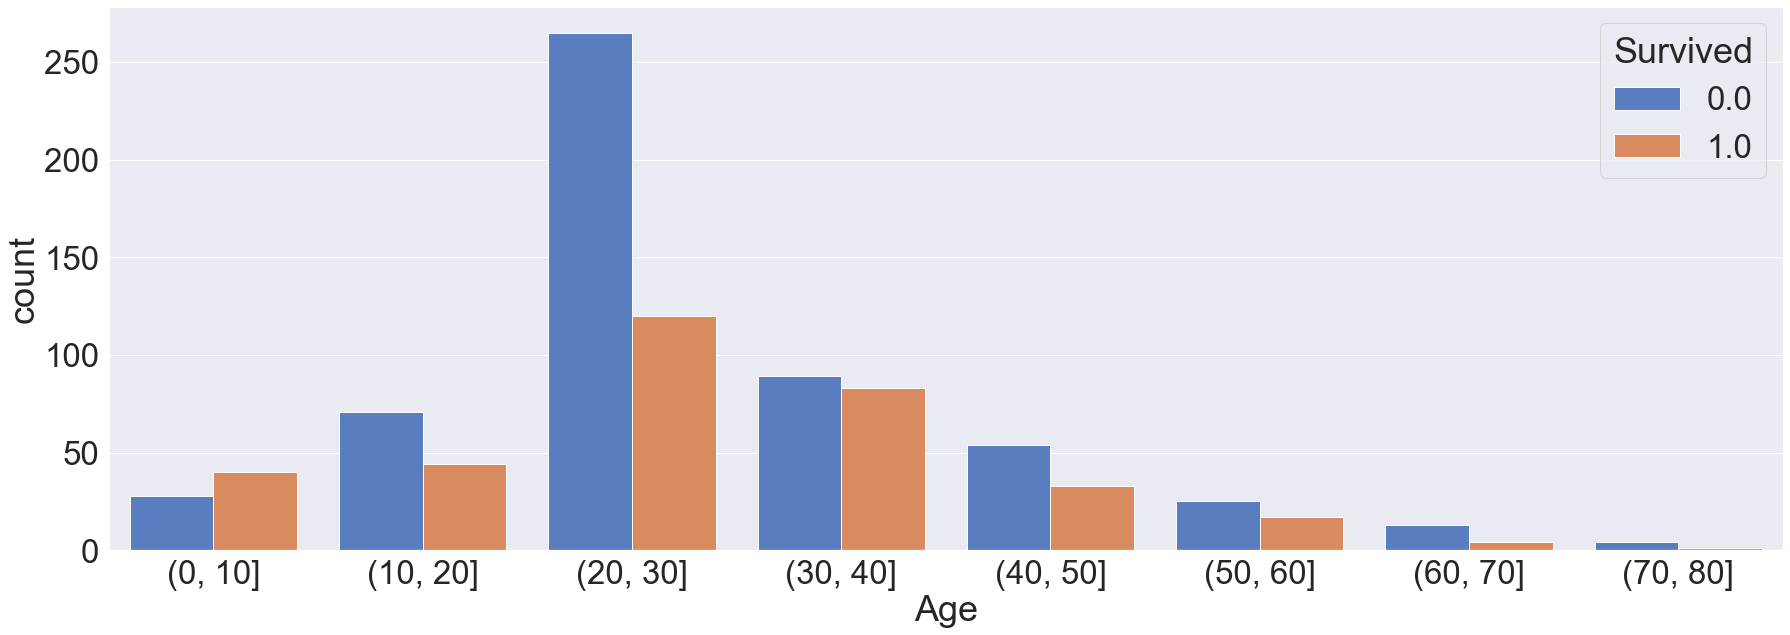

In [19]:
plt.figure(figsize=(30,10))
x = pd.cut(df.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
sns.set(font_scale = 3,  palette='muted')
sns.countplot(x=x, hue='Survived', data=df)


<AxesSubplot:xlabel='Pclass', ylabel='count'>

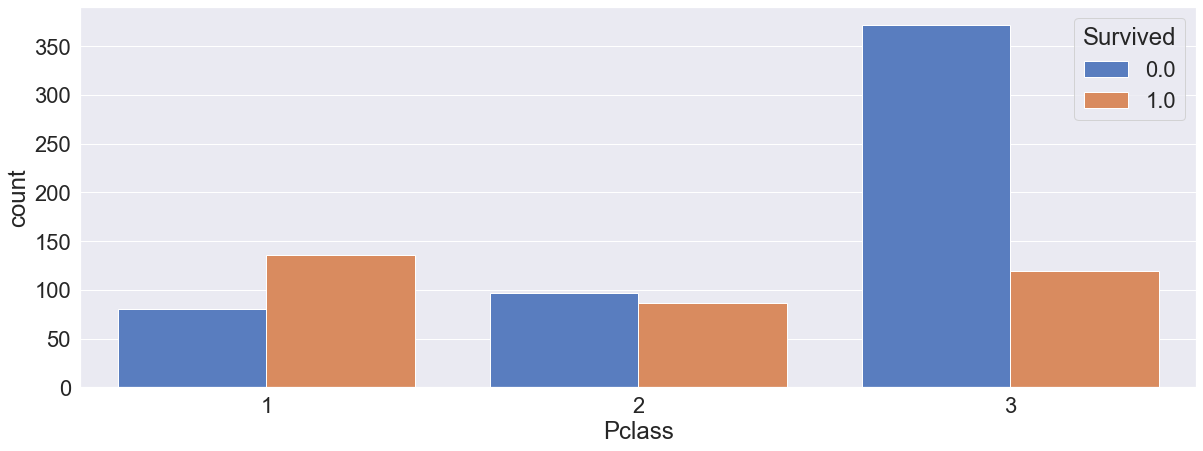

In [20]:
plt.figure(figsize=(20,7))
sns.set(font_scale = 2,  palette='muted')
sns.countplot(x='Pclass', hue='Survived', data=df)


<AxesSubplot:xlabel='family', ylabel='count'>

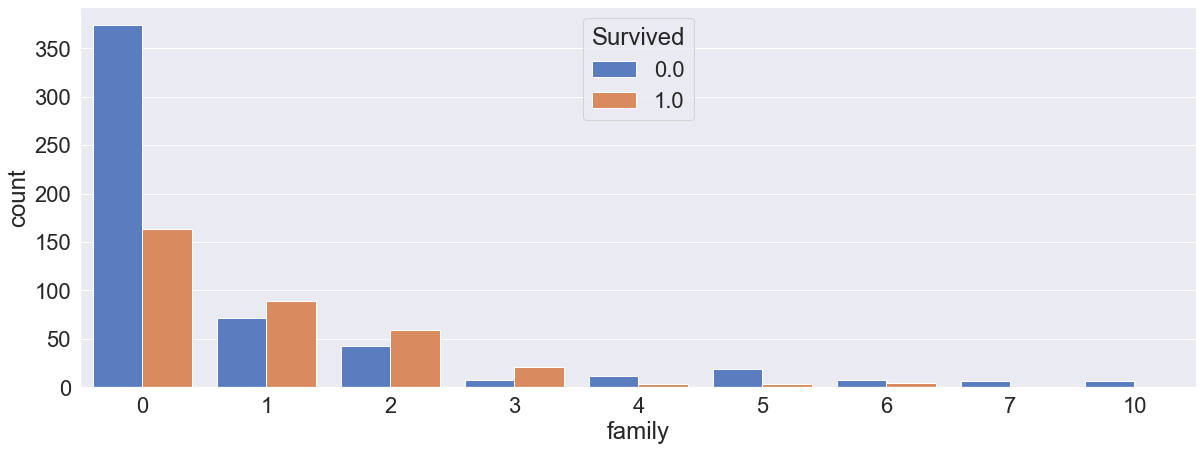

In [21]:
plt.figure(figsize=(20,7))
sns.set(font_scale = 2,  palette='muted')
sns.countplot(x='family', hue='Survived', data=df)

<AxesSubplot:xlabel='Fare', ylabel='count'>

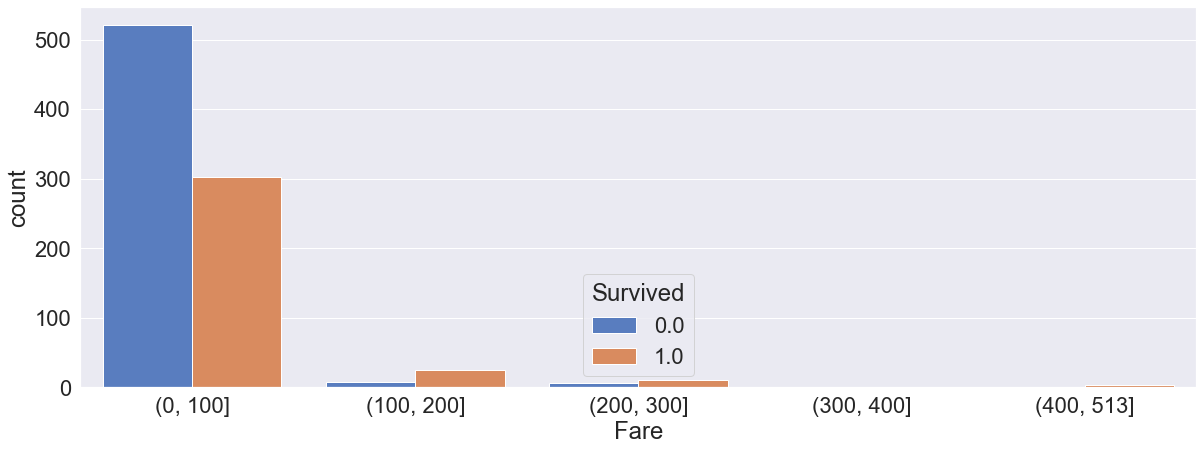

In [22]:
plt.figure(figsize=(20,7))
sns.set(font_scale = 2,  palette='muted')
x = pd.cut(df.Fare, [0, 100, 200, 300, 400, 513])
sns.countplot(x=x, hue='Survived', data=df)

<AxesSubplot:xlabel='deck', ylabel='count'>

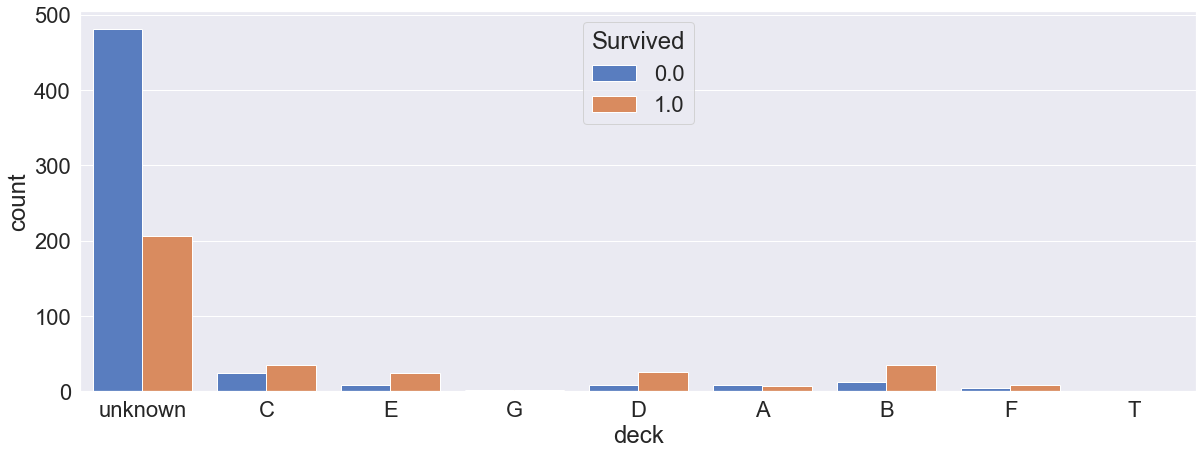

In [23]:
plt.figure(figsize=(20,7))
sns.set(font_scale = 2,  palette='muted')
sns.countplot(x='deck', hue='Survived', data=df)

<AxesSubplot:xlabel='Sex', ylabel='count'>

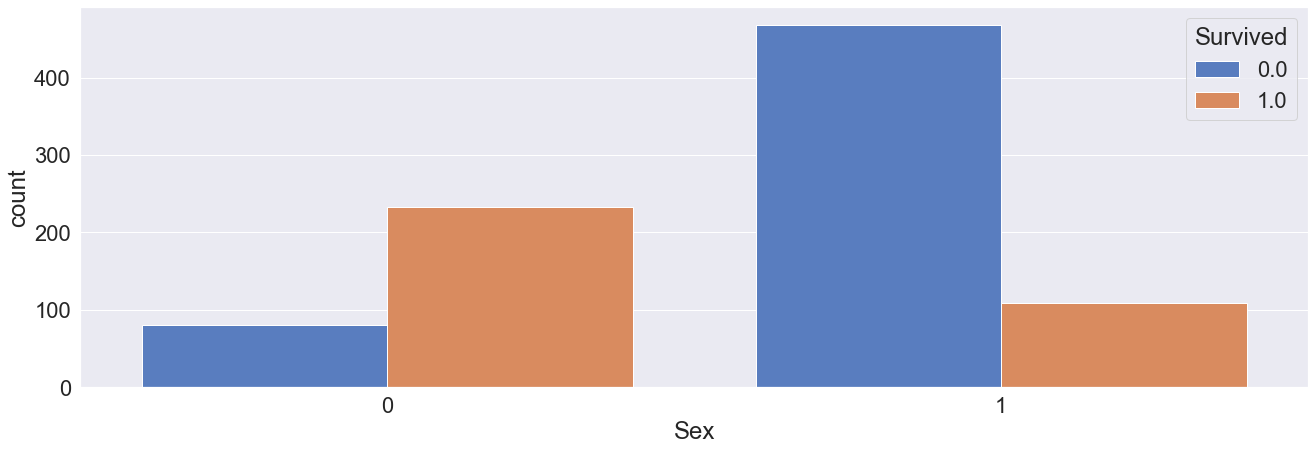

In [25]:
plt.figure(figsize=(22,7))
sns.set(font_scale = 2,  palette='muted')
sns.countplot(x='Sex', hue='Survived', data=df)

<AxesSubplot:xlabel='status', ylabel='count'>

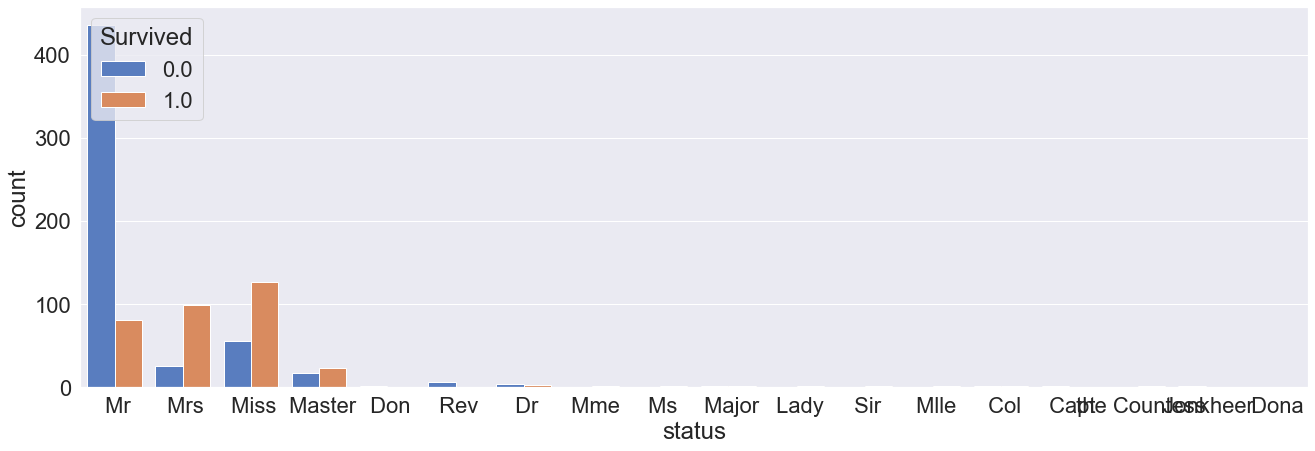

In [24]:
plt.figure(figsize=(22,7))
sns.set(font_scale = 2,  palette='muted')
sns.countplot(x='status', hue='Survived', data=df)

In [26]:
# решаю удалить данный столбец, т.к. не вижу в нем информативного прибавления
df.drop(['status'], axis = 1, inplace=True)

In [27]:
# кодируем признаки
df = pd.concat([df, 
                pd.get_dummies(df['Embarked'], prefix="Embarked"),
                pd.get_dummies(df['deck'], prefix="deck")],
                axis = 1)

In [28]:
df.drop(['Embarked', 'deck'], axis = 1, inplace=True)

____
Моделирование
___

In [29]:
train, test = df.loc[df_train.index], df.loc[df_test.index]

In [30]:
y = train.Survived

In [31]:
train.drop(['Survived'], axis = 1, inplace=True)

In [32]:
test.drop(['Survived'], axis = 1, inplace=True)

* Обучим дерево, на результатах работы, будем визуализировать само дерево и важность предикторов

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
grid = {'max_depth': (range(1, 10, 1)),
       'max_features': (range(1, 5, 1))}
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=42), grid, scoring='roc_auc', n_jobs=-1)

In [46]:
gridsearch.fit(train, y)
gridsearch.best_params_

{'max_depth': 7, 'max_features': 4}

In [47]:
clf = DecisionTreeClassifier(random_state=42, max_depth = 7, max_features = 4 )
clf.fit(train, y)

DecisionTreeClassifier(max_depth=7, max_features=4, random_state=42)

In [48]:
predicted = clf.predict(train)
print(accuracy_score(y, predicted))

0.8742985409652076


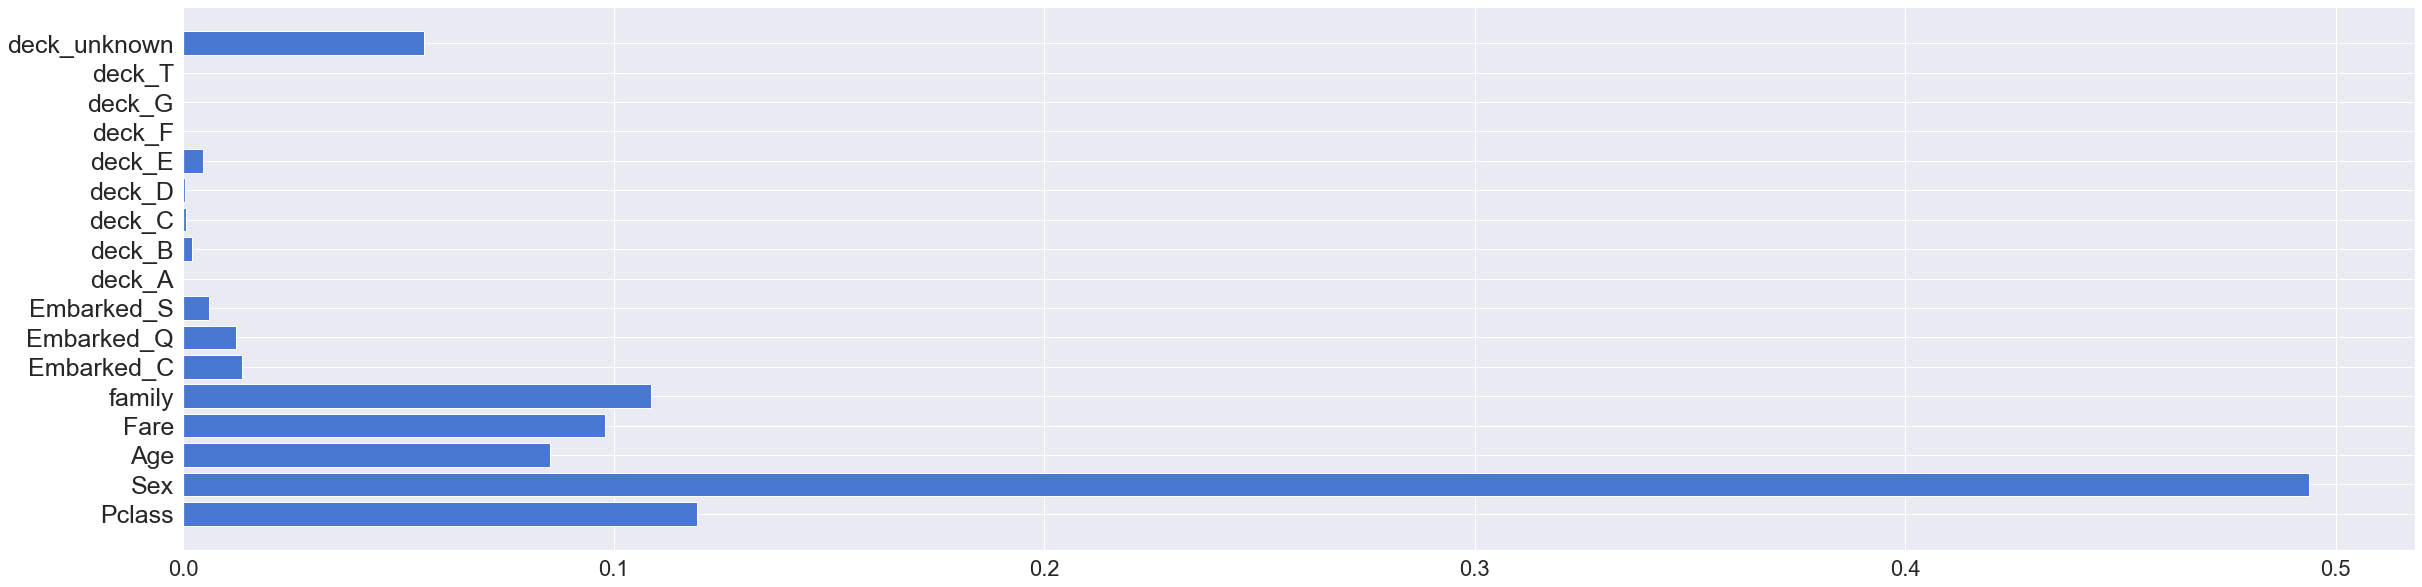

In [49]:
plt.figure(figsize=(40, 10)) 
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(train.columns)),train.columns, fontsize=25);

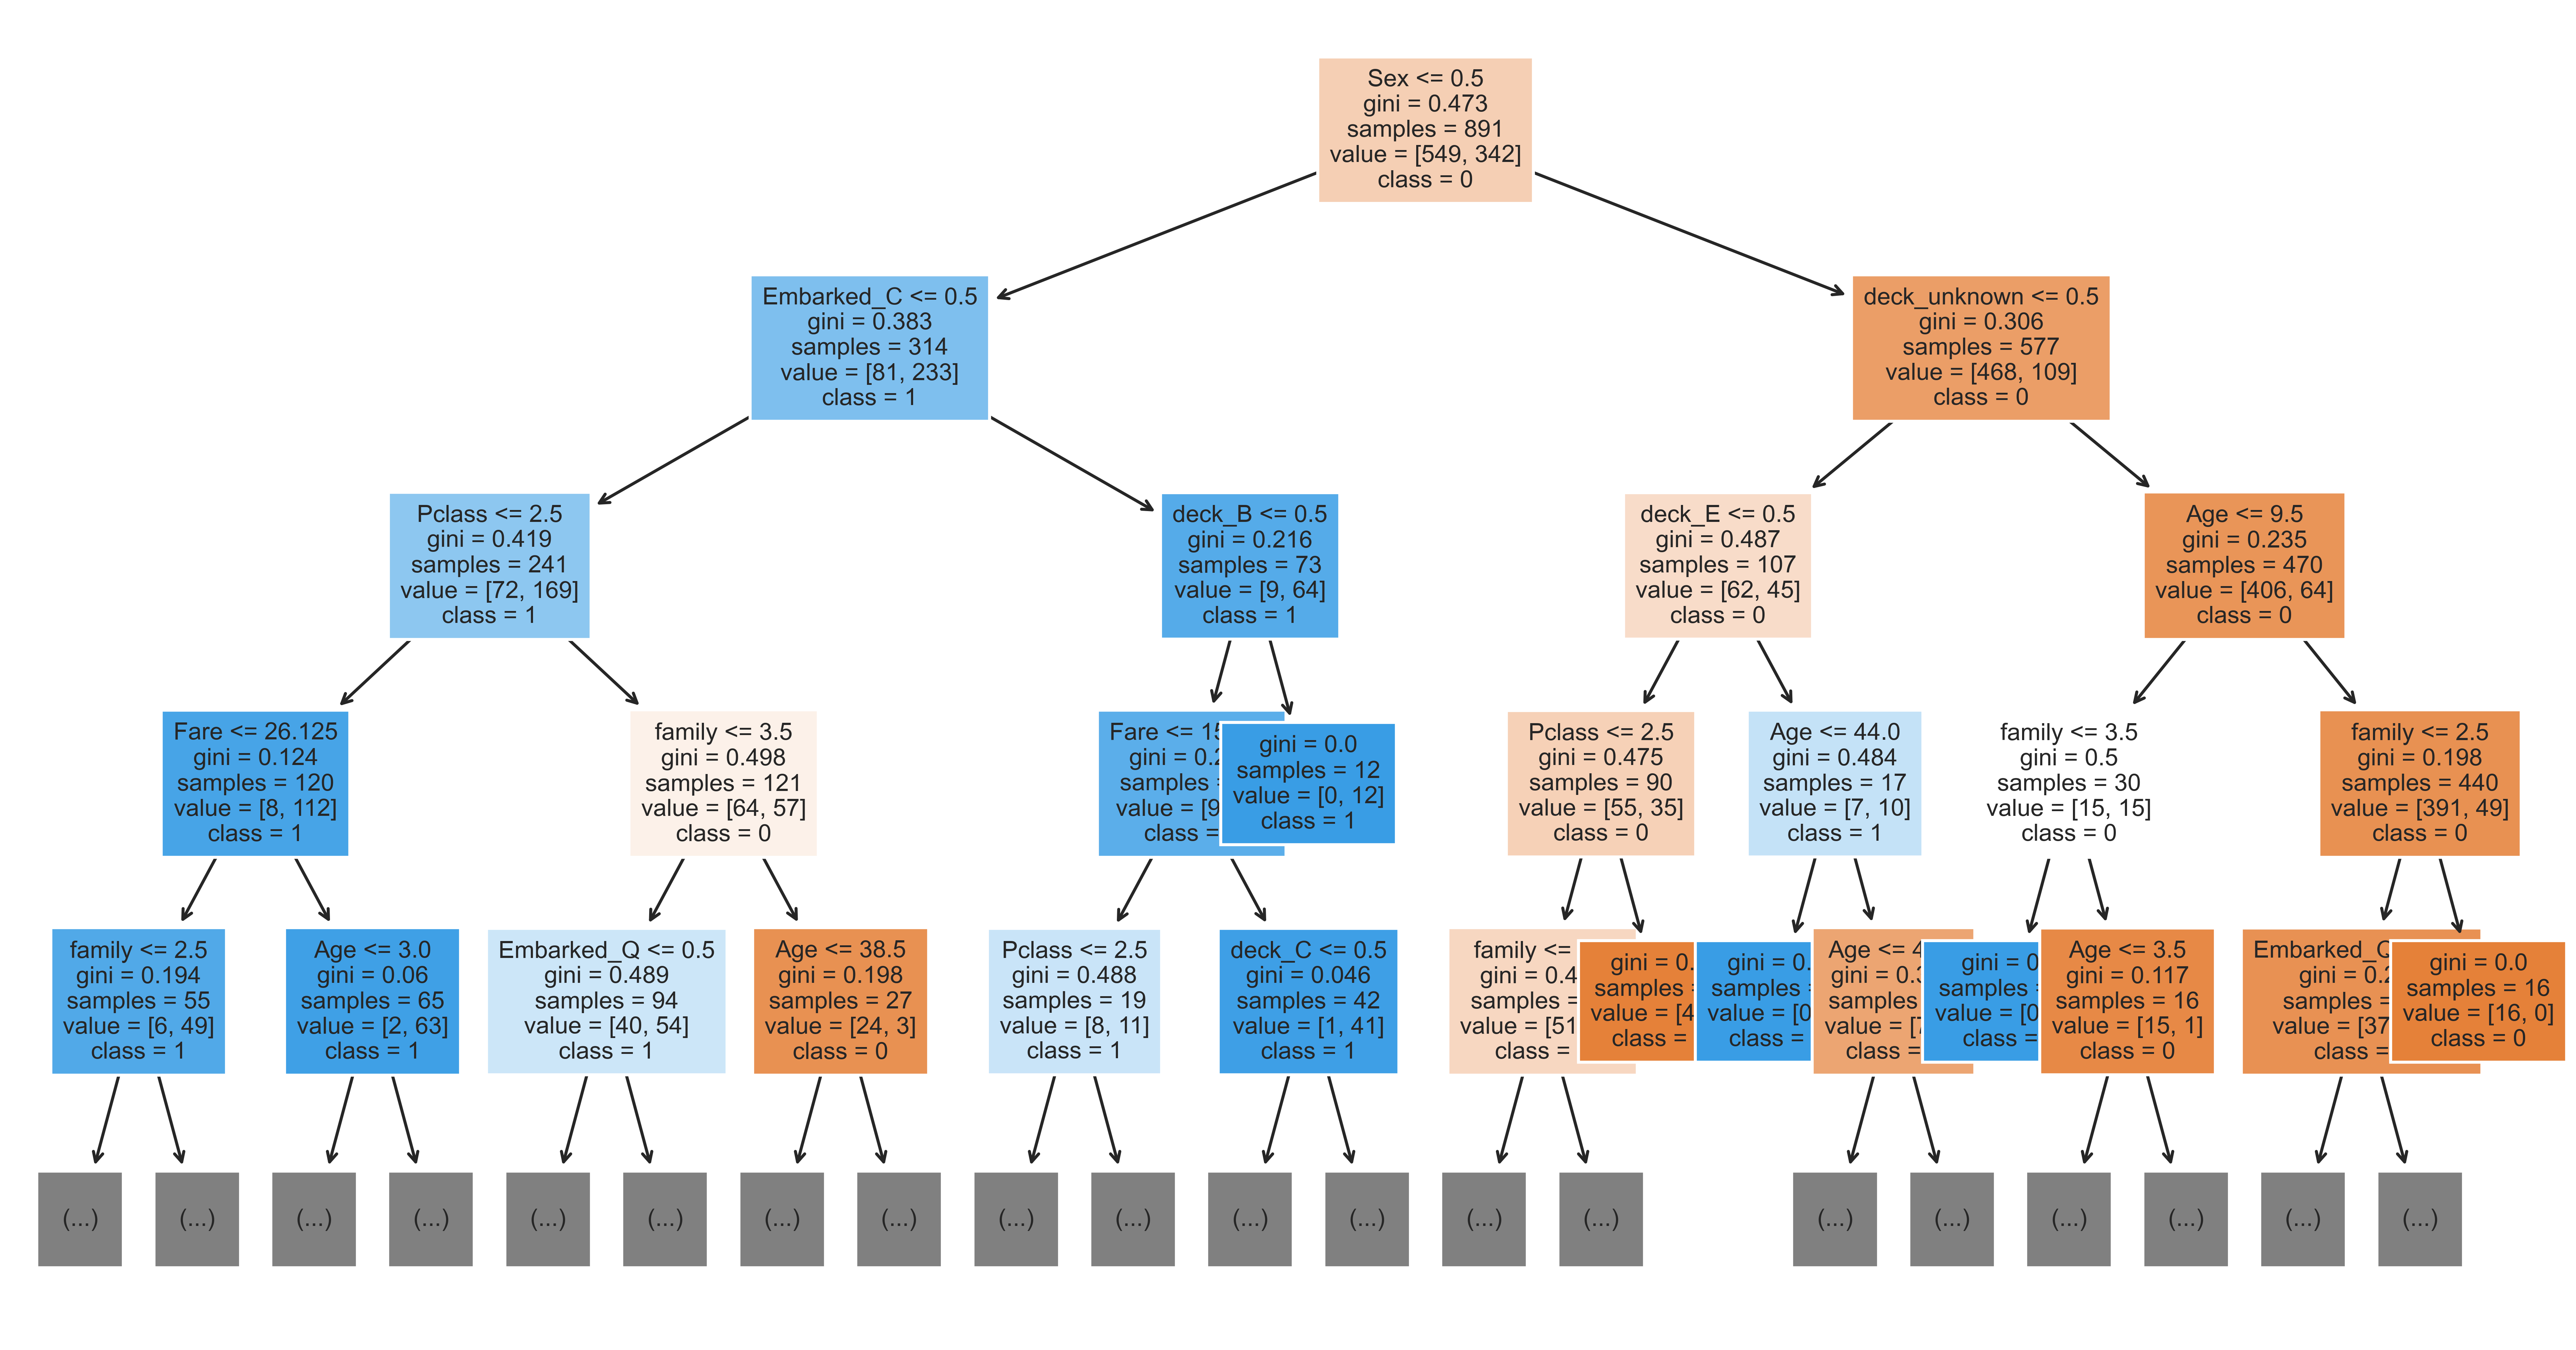

In [60]:
from sklearn import tree

fn = train.columns


fig, axes = plt.subplots(figsize = (15,8), dpi=600)
tree.plot_tree(clf, max_depth=4,
               feature_names=fn,
               class_names=['0', '1'],
               filled = True, 
               fontsize=8);

* финальные значения получим при помощи RandomForestClassifier

In [61]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth = 7,  
                             max_features = 4,
                             random_state=42)
rfc.fit(train, y)


RandomForestClassifier(max_depth=7, max_features=4, random_state=42)

In [62]:
y_pred = rfc.predict_proba(train)[:, 1]
roc_auc_score(y, y_pred)

0.9407029261070101

In [63]:
feature_names = train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

print("Важность предикторов:")
for f, idx in enumerate(indices):
    print("{:2d}. '{:5s}' ({:.4f})".format(f + 1,
                                           feature_names[idx],
                                           importances[idx]))

Важность предикторов:
 1. 'Sex  ' (0.3652)
 2. 'Fare ' (0.1736)
 3. 'Age  ' (0.1467)
 4. 'Pclass' (0.0928)
 5. 'family' (0.0774)
 6. 'deck_unknown' (0.0611)
 7. 'Embarked_S' (0.0170)
 8. 'Embarked_C' (0.0158)
 9. 'Embarked_Q' (0.0104)
10. 'deck_E' (0.0102)
11. 'deck_C' (0.0072)
12. 'deck_B' (0.0071)
13. 'deck_D' (0.0067)
14. 'deck_A' (0.0036)
15. 'deck_F' (0.0027)
16. 'deck_G' (0.0020)
17. 'deck_T' (0.0004)


In [64]:
y_pre = rfc.predict(test)
y_pre

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

#### Вывод:
* Важными данными для предсказания модели являются: пол, оплата за билет,возраст, класс билета, и количество членов семьи
* Люди у которох от 1 до 3 родственников было на борту, выживали чаще 
* Из выживших женщин больше чем мужчин
* Дети до 10 лет и люди от 30-40 выживали чаще остальных возрастных групп 
* Пасажиры находившиеся на палубах C, E, D, B, F выживали чаще 
* Цена так же влияет, чем выше была цена, тем больше выживших 